In [26]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import pandas as pd
import yellowbrick as yb
import matplotlib.pyplot as plt 

from yellowbrick.classifier import ROCAUC
from sklearn.model_selection import train_test_split

In [69]:
import numpy as np

from yellowbrick.exceptions import ModelError
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.style.palettes import LINE_COLOR
from yellowbrick.classifier.base import ClassificationScoreVisualizer

from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve


# Dictionary keys for ROCAUC
MACRO = "macro"
MICRO = "micro"


##########################################################################
## ROCAUC Visualizer
##########################################################################

class ROCAUC(ClassificationScoreVisualizer):
    """
    Receiver Operating Characteristic (ROC) curves are a measure of a
    classifier's predictive quality that compares and visualizes the tradeoff
    between the models' sensitivity and specificity. The ROC curve displays
    the true positive rate on the Y axis and the false positive rate on the
    X axis on both a global average and per-class basis. The ideal point is
    therefore the top-left corner of the plot: false positives are zero and
    true positives are one.

    This leads to another metric, area under the curve  (AUC), a computation
    of the relationship between false positives and true positives. The higher
    the AUC, the better the model generally is. However, it is also important
    to inspect the "steepness" of the curve, as this describes the
    maximization of the true positive rate while minimizing the false positive
    rate. Generalizing "steepness" usually leads to discussions about
    convexity, which we do not get into here.

    Parameters
    ----------
    model : estimator
        Must be a classifier, otherwise raises YellowbrickTypeError

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    classes : list
        A list of class names for the legend. If classes is None and a y value
        is passed to fit then the classes are selected from the target vector.
        Note that the curves must be computed based on what is in the target
        vector passed to the ``score()`` method. Class names are used for
        labeling only and must be in the correct order to prevent confusion.

    micro : bool, default = True
        Plot the micro-averages ROC curve, computed from the sum of all true
        positives and false positives across all classes.

    macro : bool, default = True
        Plot the macro-averages ROC curve, which simply takes the average of
        curves across all classes.

    per_class : bool, default = True
        Plot the ROC curves for each individual class. This should be set
        to false if only the macro or micro average curves are required.

    kwargs : keyword arguments passed to the super class.
        Currently passing in hard-coded colors for the Receiver Operating
        Characteristic curve and the diagonal.
        These will be refactored to a default Yellowbrick style.

    Attributes
    ----------
    score_ : float
        Global accuracy score, unless micro or macro scores are requested

    Notes
    -----
    ROC curves are typically used in binary classification, and in fact the
    Scikit-Learn ``roc_curve`` metric is only able to perform metrics for
    binary classifiers. As a result it is necessary to binarize the output or
    to use one-vs-rest or one-vs-all strategies of classification. The
    visualizer does its best to handle multiple situations, but exceptions can
    arise from unexpected models or outputs.

    Another important point is the relationship of class labels specified on
    initialization to those drawn on the curves. The classes are not used to
    constrain ordering or filter curves; the ROC computation happens on the
    unique values specified in the target vector to the ``score`` method. To
    ensure the best quality visualization, do not use a LabelEncoder for this
    and do not pass in class labels.

    .. seealso:: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    .. todo:: Allow the class list to filter the curves on the visualization.

    Examples
    --------
    >>> from sklearn.datasets import load_breast_cancer
    >>> from yellowbrick.classifier import ROCAUC
    >>> from sklearn.linear_model import LogisticRegression
    >>> from sklearn.model_selection import train_test_split
    >>> data = load_breast_cancer()
    >>> X = data['data']
    >>> y = data['target']
    >>> X_train, X_test, y_train, y_test = train_test_split(X, y)
    >>> viz = ROCAUC(LogisticRegression())
    >>> viz.fit(X_train, y_train)
    >>> viz.score(X_test, y_test)
    >>> viz.show()
    """

    def __init__(self, model, ax=None, classes=None,
                 micro=True, macro=True, per_class=True, **kwargs):
        super(ROCAUC, self).__init__(model, ax=ax, classes=classes, **kwargs)

        # Set the visual parameters for ROCAUC
        self.micro = micro
        self.macro = macro
        self.per_class = per_class

    def score(self, X, y=None, **kwargs):
        """
        Generates the predicted target values using the Scikit-Learn
        estimator.

        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features

        y : ndarray or Series of length n
            An array or series of target or class values

        Returns
        -------
        score_ : float
            Global accuracy unless micro or macro scores are requested.
        """

        # Compute the predictions for the test data
        y_pred = self._get_y_scores(X)
        
        if len(y_pred.shape) == 1:
            self._binary_decision = True
            
            if self.micro or self.macro or self.per_class:
                raise ModelError(
                    "Micro, macro, and per-class scores are not defined for "
                    "binary classification for estimators with only " 
                    "decision_function methods; set micro, macro, and "
                    "per-class params to False."
                )
        else:
            self._binary_decision = False
            if not self.micro and not self.macro and not self.per_class:
                raise YellowbrickValueError(
                    "no curves will be drawn; specify micro, macro, or per_class"
                )
                
        # Classes may be label encoded so only use what's in y to compute.
        # The self.classes_ attribute will be used as names for labels.
        classes = np.unique(y)
        n_classes = len(classes)

        # Store the false positive rate, true positive rate and curve info.
        self.fpr = dict()
        self.tpr = dict()
        self.roc_auc = dict()

        # Compute ROC curve and ROC area for each class
        if self._binary_decision == True:
            self.fpr[0], self.tpr[0], _ = roc_curve(y, y_pred)
            self.roc_auc[0] = auc(self.fpr[0], self.tpr[0])
        else: 
            for i, c in enumerate(classes):
                self.fpr[i], self.tpr[i], _ = roc_curve(y, y_pred[:,i], pos_label=c)
                self.roc_auc[i] = auc(self.fpr[i], self.tpr[i])

        # Compute micro average
        if self.micro:
            self._score_micro_average(y, y_pred, classes, n_classes)

        # Compute macro average
        if self.macro:
            self._score_macro_average(y_pred, n_classes)

        # Draw the Curves
        self.draw()

        # Set score to micro average if specified
        if self.micro:
            self.score_ = self.roc_auc[MICRO]

        # Set score to macro average if not micro
        if self.macro:
            self.score_ = self.roc_auc[MACRO]

        # Set score to the base score if neither macro nor micro
        self.score_ = self.estimator.score(X, y)

        return self.score_

    def draw(self):
        """
        Renders ROC-AUC plot.
        Called internally by score, possibly more than once

        Returns
        -------
        ax : the axis with the plotted figure
        """
        colors = self.colors[0:len(self.classes_)]
        n_classes = len(colors)

        # If binary decision, plot the ROC curve
        if self._binary_decision == True:
            self.ax.plot(
                self.fpr[0], self.tpr[0],
                label='ROC for binary decision, AUC = {:0.2f}'.format(
                        self.roc_auc[0]
                )
            )
        # Otherwise plot the ROC curves for each class
        if self.per_class:
            for i, color in zip(range(n_classes), colors):
                self.ax.plot(
                    self.fpr[i], self.tpr[i], color=color,
                    label='ROC of class {}, AUC = {:0.2f}'.format(
                        self.classes_[i], self.roc_auc[i],
                    )
                )

        # Plot the ROC curve for the micro average
        if self.micro:
            self.ax.plot(
                self.fpr[MICRO], self.tpr[MICRO], linestyle="--",
                color= self.colors[len(self.classes_)-1],
                label='micro-average ROC curve, AUC = {:0.2f}'.format(
                    self.roc_auc["micro"],
                )
            )

        # Plot the ROC curve for the macro average
        if self.macro:
            self.ax.plot(
                self.fpr[MACRO], self.tpr[MACRO], linestyle="--",
                color= self.colors[len(self.classes_)-1],
                label='macro-average ROC curve, AUC = {:0.2f}'.format(
                    self.roc_auc["macro"],
                )
            )

        # Plot the line of no discrimination to compare the curve to.
        self.ax.plot([0,1], [0,1], linestyle=':', c=LINE_COLOR)
        return self.ax

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls show and show calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.

        """
        # Set the title and add the legend
        self.set_title('ROC Curves for {}'.format(self.name))
        self.ax.legend(loc='lower right', frameon=True)

        # Set the limits for the ROC/AUC (always between 0 and 1)
        self.ax.set_xlim([0.0, 1.0])
        self.ax.set_ylim([0.0, 1.0])

        # Set x and y axis labels
        self.ax.set_ylabel('True Postive Rate')
        self.ax.set_xlabel('False Positive Rate')

    def _get_y_scores(self, X):
        """
        The ``roc_curve`` metric requires target scores that can either be the
        probability estimates of the positive class, confidence values or non-
        thresholded measure of decisions (as returned by "decision_function").

        This method computes the scores by resolving the estimator methods
        that retreive these values.

        .. todo:: implement confidence values metric.

        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features -- generally the test data
            that is associated with y_true values.
        """
        # The resolution order of scoring functions
        attrs = (
            'predict_proba',
            'decision_function',
        )

        # Return the first resolved function
        for attr in attrs:
            try:
                method = getattr(self.estimator, attr, None)
                if method:
                    return method(X)
            except AttributeError:
                # Some Scikit-Learn estimators have both probability and
                # decision functions but override __getattr__ and raise an
                # AttributeError on access.
                continue

        # If we've gotten this far, raise an error
        raise ModelError(
            "ROCAUC requires estimators with predict_proba or "
            "decision_function methods."
        )

    def _score_micro_average(self, y, y_pred, classes, n_classes):
        """
        Compute the micro average scores for the ROCAUC curves.
        """
        # Convert y to binarized array for micro and macro scores
        y = label_binarize(y, classes=classes)
        if n_classes == 2:
            y = np.hstack((1-y, y))

        # Compute micro-average
        self.fpr[MICRO], self.tpr[MICRO], _ = roc_curve(y.ravel(), y_pred.ravel())
        self.roc_auc[MICRO] = auc(self.fpr[MICRO], self.tpr[MICRO])

    def _score_macro_average(self, y_pred, n_classes):
        """
        Compute the macro average scores for the ROCAUC curves.
        """   
        # Gather all FPRs
        all_fpr = np.unique(np.concatenate([self.fpr[i] for i in range(n_classes)]))
        avg_tpr = np.zeros_like(all_fpr)

        # Compute the averages per class
        for i in range(n_classes):
            avg_tpr += interp(all_fpr, self.fpr[i], self.tpr[i])

        # Finalize the average
        avg_tpr /= n_classes

        # Store the macro averages
        self.fpr[MACRO] = all_fpr
        self.tpr[MACRO] = avg_tpr
        self.roc_auc[MACRO] = auc(self.fpr[MACRO], self.tpr[MACRO])


##########################################################################
## Quick method for ROCAUC
##########################################################################

def roc_auc(model, X, y=None, ax=None, **kwargs):
    """ROCAUC Quick method:

    Receiver Operating Characteristic (ROC) curves are a measure of a
    classifier's predictive quality that compares and visualizes the tradeoff
    between the models' sensitivity and specificity. The ROC curve displays
    the true positive rate on the Y axis and the false positive rate on the
    X axis on both a global average and per-class basis. The ideal point is
    therefore the top-left corner of the plot: false positives are zero and
    true positives are one.

    This leads to another metric, area under the curve  (AUC), a computation
    of the relationship between false positives and true positives. The higher
    the AUC, the better the model generally is. However, it is also important
    to inspect the "steepness" of the curve, as this describes the
    maximization of the true positive rate while minimizing the false positive
    rate. Generalizing "steepness" usually leads to discussions about
    convexity, which we do not get into here.

    Parameters
    ----------
    model : the Scikit-Learn estimator
        Should be an instance of a classifier, else the __init__ will
        return an error.

    X : ndarray or DataFrame of shape n x m
        A matrix of n instances with m features

    y : ndarray or Series of length n
        An array or series of target or class values

    ax : the axis to plot the figure on.

    classes : list
        A list of class names for the legend. If classes is None and a y value
        is passed to fit then the classes are selected from the target vector.
        Note that the curves must be computed based on what is in the target
        vector passed to the ``score()`` method. Class names are used for
        labeling only and must be in the correct order to prevent confusion.

    micro : bool, default = True
        Plot the micro-averages ROC curve, computed from the sum of all true
        positives and false positives across all classes.

    macro : bool, default = True
        Plot the macro-averages ROC curve, which simply takes the average of
        curves across all classes.

    per_class : bool, default = True
        Plot the ROC curves for each individual class. Primarily this is set
        to false if only the macro or micro average curves are required.

    Notes
    -----
    ROC curves are typically used in binary classification, and in fact the
    Scikit-Learn ``roc_curve`` metric is only able to perform metrics for
    binary classifiers. As a result it is necessary to binarize the output or
    to use one-vs-rest or one-vs-all strategies of classification. The
    visualizer does its best to handle multiple situations, but exceptions can
    arise from unexpected models or outputs.

    Another important point is the relationship of class labels specified on
    initialization to those drawn on the curves. The classes are not used to
    constrain ordering or filter curves; the ROC computation happens on the
    unique values specified in the target vector to the ``score`` method. To
    ensure the best quality visualization, do not use a LabelEncoder for this
    and do not pass in class labels.

    .. seealso:: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    .. todo:: Allow the class list to filter the curves on the visualization.

    Examples
    --------
    >>> from sklearn.datasets import load_breast_cancer
    >>> from yellowbrick.classifier import roc_auc
    >>> from sklearn.linear_model import LogisticRegression
    >>> data = load_breast_cancer()
    >>> roc_auc(LogisticRegression(), data.data, data.target)

    Returns
    -------
    ax : matplotlib axes
        Returns the axes that the roc-auc curve was drawn on.
    """
    # Instantiate the visualizer
    visualizer = ROCAUC(model, ax, **kwargs)

    # Create the train and test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit and transform the visualizer (calls draw)
    visualizer.fit(X_train, y_train, **kwargs)
    visualizer.score(X_test, y_test)
    visualizer.finalize()

    # Return the axes object on the visualizer
    return visualizer.ax


In [70]:
occupancy = pd.read_csv('data/occupancy/occupancy.csv')
features = [
    "temperature", "relative humidity", "light", "C02", "humidity"
]
classes = ["unoccupied", "occupied"]
X = occupancy[features]
y = occupancy['occupancy']

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

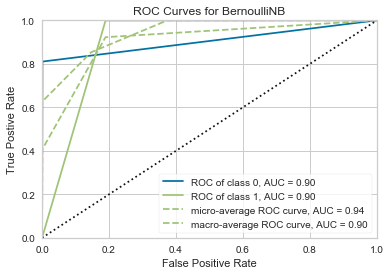

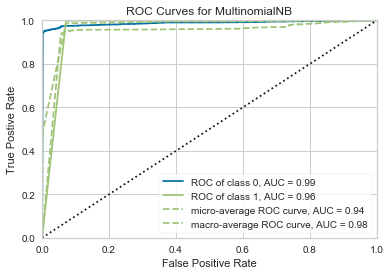

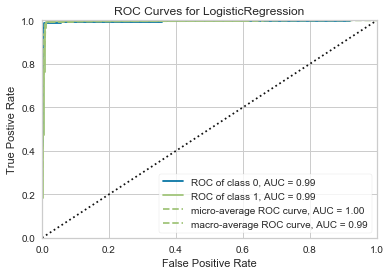

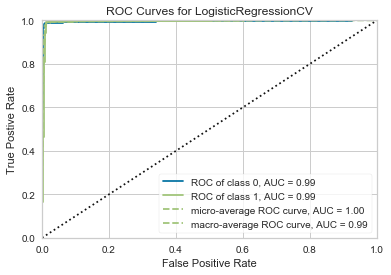

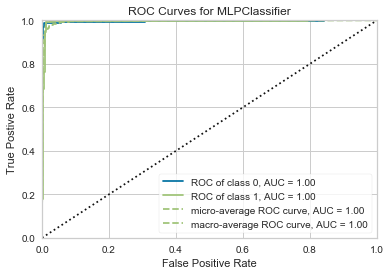

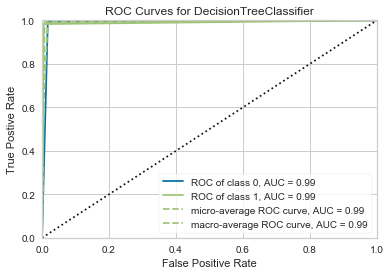

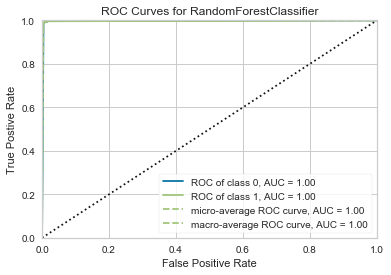

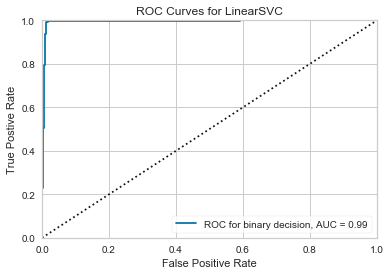

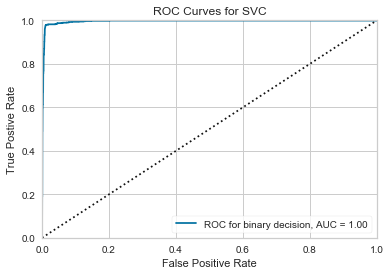

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


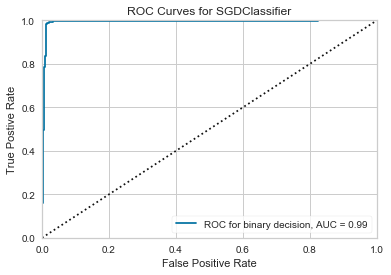

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


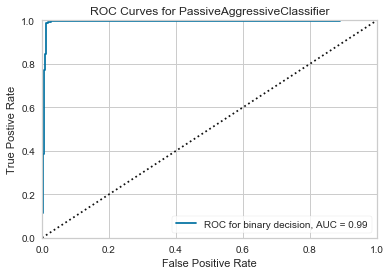

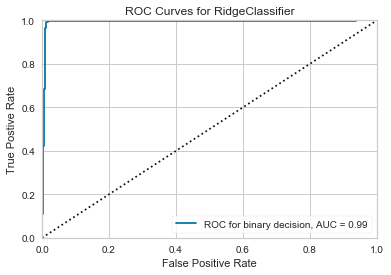

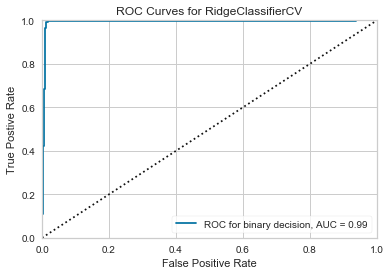

In [77]:
multi_classifiers = [
    BernoulliNB(),
    MultinomialNB(),
    LogisticRegression(),
    LogisticRegressionCV(),
    MLPClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]

binary_classifiers = [
    LinearSVC(),                   
    SVC(),                     
    SGDClassifier(),              
    PassiveAggressiveClassifier(), 
    RidgeClassifier(),             
    RidgeClassifierCV()
]

for classifier in multi_classifiers:
    oz = ROCAUC(classifier)
    oz.fit(X_train, y_train)
    oz.score(X_test, y_test)
    g = oz.show()
    
for classifier in binary_classifiers:
    oz = ROCAUC(classifier, micro=False, macro=False, per_class=False)
    oz.fit(X_train, y_train)
    oz.score(X_test, y_test)
    g = oz.show()